In [14]:
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torch import nn
import torch.nn.functional as F
import torch
from torch.optim import Adam

from torch import cuda

from torchinfo import summary

import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
from tqdm import tqdm
import os
import re
import typing

In [15]:
### Parameters
batch_size = 64
crop_size = 256
image_size = 102

skip_t00 = False
save_t00 = True
load_t00 = False

skip_ec = True
save_ec = True
load_ec = False

torch.manual_seed(12)

if cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

### Hyperparams
learning_rate = 0.002

In [16]:
class GZ2Dataset(Dataset):
    def __init__(self, csv_file_maps: str, csv_file_data: str, root_dir: str, transform = None) -> None:
        """
        Initializes the dataset.

        Parameters:
            csv_file_maps (str): Name of *.csv file that contains the filename to id mapping for the images
            csv_file_data (str): Name of *.csv file that contains the labeled data for every id
            root_dir (str): Directory containing all the images
            transform (class from torchvision.transforms): Transform to be used on the image data
        """
        self.maps = pd.read_csv(csv_file_maps)
        self.data = pd.read_csv(csv_file_data)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self) -> int:
        """
        Returns the size of the dataset as number of elements.

        Returns:
            int: Number of elements
        """
        return len(self.data)
    
    def __getitem__(self, index: int) -> tuple:
        """
        Returns an element from the dataset for a given index.

        Parameters:
            index (int): The index of the element to be returned

        Returns:
            tuple: Tuple in the form of (image_data: torch.Tensor, datapoint_1, datapoint_2, ...)

        """
        image_data = self.data.iloc[index]

        # Value of the "dr7objid" field for the current element
        dr7objid = image_data['dr7objid']

        filename = str(self.maps[self.maps['objid'] == dr7objid]['asset_id'].item()) + '.jpg'
        image_path = os.path.join(self.root_dir, filename)
        image = io.imread(image_path) # Load image as numpy tensor with normalized color values

        # Select prediction (for t01) from maximum percentage of votes 
        predictions_t01 = [image_data.to_numpy()[14], image_data.to_numpy()[20], image_data.to_numpy()[26]]
        prediction_t01 = predictions_t01.index(max(predictions_t01))

        predictions_t02 = [image_data.to_numpy()[32], image_data.to_numpy()[38]]
        prediction_t02 = predictions_t02.index(max(predictions_t02))

        # Possible predictions:
        # 0:= smooth
        # 1:= features
        # 2:= star

        if self.transform:
            image = self.transform(image)

        output = tuple([image.to(device), torch.tensor(prediction_t01).to(device), torch.tensor(prediction_t02).to(device)])

        return output
    
    def preprocess(self):
        """
        Removes all rows from the list, where the difference between the fractions of votes on smooth vs. featured is less than 20%.
        Additionally reserves last 15% of remaining dataset for test data.
        """
        self.data = self.data[abs(self.data['t01_smooth_or_features_a01_smooth_weighted_fraction'] - self.data['t01_smooth_or_features_a02_features_or_disk_weighted_fraction']) > 0.2]
        self.test_data = self.data.iloc[-round(0.15*len(self.data)):,:]
        self.data = self.data.iloc[:-round(0.15*len(self.data)),:] # Reserve last 15% of elements for testing
        self.data.reset_index()


class GZ2Dataset_TEST(GZ2Dataset):
    def __init__(self, csv_file_maps: str, csv_file_data: str, root_dir: str, transform = None) -> None:
        super(GZ2Dataset_TEST, self).__init__(csv_file_maps, csv_file_data, root_dir, transform)
        self.preprocess()
    
    def __getitem__(self, index: int) -> tuple:
        """
        Returns an element from the test dataset for a given index.

        Parameters:
            index (int): The index of the element to be returned

        Returns:
            tuple: Tuple in the form of (image_data: torch.Tensor, datapoint_1, datapoint_2, ...)

        """
        image_data = self.test_data.iloc[index]

        # Value of the "dr7objid" field for the current element
        dr7objid = image_data['dr7objid']

        filename = str(self.maps[self.maps['objid'] == dr7objid]['asset_id'].item()) + '.jpg'
        image_path = os.path.join(self.root_dir, filename)
        image = io.imread(image_path) # Load image as numpy tensor with normalized color values

        # Select prediction (for t01) from maximum percentage of votes 
        predictions_t01 = [image_data.to_numpy()[14], image_data.to_numpy()[20], image_data.to_numpy()[26]]
        prediction_t01 = predictions_t01.index(max(predictions_t01))

        predictions_t02 = [image_data.to_numpy()[32], image_data.to_numpy()[38]]
        prediction_t02 = predictions_t02.index(max(predictions_t02))

        # Possible predictions:
        # 0:= smooth
        # 1:= features
        # 2:= star

        if self.transform:
            image = self.transform(image)

        output = tuple([image.to(device), torch.tensor(prediction_t01).to(device), torch.tensor(prediction_t02).to(device)])

        return output

In [17]:
class GZ2Dataset_EC(GZ2Dataset):
    def __init__(self, csv_file_maps: str, csv_file_data: str, root_dir: str, transform = None) -> None:
        super(GZ2Dataset_EC, self).__init__(csv_file_maps, csv_file_data, root_dir, transform)

    def __getitem__(self, index: int) -> typing.Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns an element from the dataset for a given index.

        Parameters:
            index (int): The index of the element to be returned

        Returns:
            tuple: Tuple in the form of (image_data: torch.Tensor, expert_classification: str)

        """
        # Value of the "dr7objid" field for the current element
        dr7objid = self.data.iloc[index]['dr7objid']

        filename = str(self.maps[self.maps['objid'] == dr7objid]['asset_id'].item()) + '.jpg'
        image_path = os.path.join(self.root_dir, filename)
        image = io.imread(image_path) # Load image as numpy tensor with normalized color values

        # Labels from expert classification
        try:
            label = re.findall("([S|E][A-B]?[A-B]?[a-z])", self.data.iloc[[index]]['gz2_class'].item())[0]
        except:
            label = 'A'

        labels = ['A', 'Ec', 'Ei', 'Er', 'SBa', 'SBb', 'SBc', 'SBd', 'Sa', 'Sb', 'Sc', 'Sd', 'Se']
        label = labels.index(label)

        if self.transform:
            image = self.transform(image)

        output = tuple([image.to(device), torch.tensor(label)])

        return output
    
class GZ2Dataset_EC_TEST(GZ2Dataset_EC):
    def __init__(self, csv_file_maps: str, csv_file_data: str, root_dir: str, transform = None) -> None:
        super(GZ2Dataset_EC_TEST, self).__init__(csv_file_maps, csv_file_data, root_dir, transform)
        self.preprocess()
    
    def __getitem__(self, index: int) -> tuple:
        """
        Returns an element from the test dataset for a given index.

        Parameters:
            index (int): The index of the element to be returned

        Returns:
            tuple: Tuple in the form of (image_data: torch.Tensor, datapoint_1, datapoint_2, ...)

        """
        # Value of the "dr7objid" field for the current element
        dr7objid = self.test_data.iloc[index]['dr7objid']

        filename = str(self.maps[self.maps['objid'] == dr7objid]['asset_id'].item()) + '.jpg'
        image_path = os.path.join(self.root_dir, filename)
        image = io.imread(image_path) # Load image as numpy tensor with normalized color values

        # Labels from expert classification
        try:
            label = re.findall("([S|E][A-B]?[A-B]?[a-z])", self.data.iloc[[index]]['gz2_class'].item())[0]
        except:
            label = 'A'

        labels = ['A', 'Ec', 'Ei', 'Er', 'SBa', 'SBb', 'SBc', 'SBd', 'Sa', 'Sb', 'Sc', 'Sd', 'Se']
        label = labels.index(label)

        if self.transform:
            image = self.transform(image)

        output = tuple([image.to(device), torch.tensor(label)])

        return output

In [18]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.RandomRotation(degrees=(0,180)), 
                                transforms.CenterCrop(crop_size), 
                                transforms.Resize(image_size)]) # Transforms to be used on the data

dataset = GZ2Dataset(csv_file_maps='gz2_filename_mapping.csv', 
                     csv_file_data='gz2_hart16_cleaned.csv', 
                     root_dir='images_gz2/images/', 
                     transform=transform)

testset = GZ2Dataset_TEST(csv_file_maps='gz2_filename_mapping.csv',
                          csv_file_data='gz2_hart16_cleaned.csv',
                          root_dir='images_gz2/images/',
                          transform=transform)

dataset.preprocess()

# Split dataset into training and validation data using 80% of the dataset for training and 20% for validation 
trainset, valset = random_split(dataset, [round(0.8*len(dataset)), round(0.2*len(dataset))])

In [19]:
dataset_ec = GZ2Dataset_EC(csv_file_maps='gz2_filename_mapping.csv', 
                     csv_file_data='gz2_hart16_cleaned.csv', 
                     root_dir='images_gz2/images/', 
                     transform=transform)

testset_ec = GZ2Dataset_EC_TEST(csv_file_maps='gz2_filename_mapping.csv',
                          csv_file_data='gz2_hart16_cleaned.csv',
                          root_dir='images_gz2/images/',
                          transform=transform)

dataset_ec.preprocess()

# Split dataset into training and validation data using 80% of the dataset for training and 20% for validation 
trainset_ec, valset_ec = random_split(dataset_ec, [round(0.8*len(dataset_ec)), round(0.2*len(dataset_ec))])

In [20]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)
print(len(dataset))

181191


In [21]:
trainloader_ec = DataLoader(trainset_ec, batch_size=batch_size, shuffle=True)
valloader_ec = DataLoader(valset_ec, batch_size=batch_size, shuffle=True)
testloader_ec = DataLoader(testset_ec, batch_size=batch_size, shuffle=True)

In [22]:
class CNN_T00(nn.Module):
    def __init__(self, save_file: str):
        super(CNN_T00, self).__init__()
        self.save_file = save_file
        
        self.net = nn.Sequential(nn.Conv2d(3, 32, 3),
                                 nn.MaxPool2d((2,2)),
                                 nn.Dropout(0.1),

                                 nn.Conv2d(32, 64, 3),
                                 nn.MaxPool2d((2,2)),
                                 nn.Dropout(0.1),

                                 nn.Conv2d(64, 128, 3),
                                 nn.MaxPool2d((2,2)),
                                 nn.Dropout(0.2),

                                 nn.Conv2d(128, 256, 3),
                                 nn.MaxPool2d((2,2)),
                                 nn.Dropout(0.3),

                                 nn.Flatten(),

                                 nn.Linear(256 * 4 * 4, 128),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),

                                 nn.Linear(128, 32),
                                 nn.LeakyReLU(),
                                 nn.Dropout(0.5),
                                 
                                 nn.Linear(32, 3))
    
    def forward(self, x):
        x = self.net(x)
        return x

In [23]:
class CNN_EC(nn.Module):
    def __init__(self, save_file: str):
        super(CNN_EC, self).__init__()
        self.save_file = save_file
        
        self.net = nn.Sequential(nn.Conv2d(3, 32, 3, padding=1),
                                 nn.MaxPool2d((2,2)),
                                 nn.Dropout(0.1),

                                 nn.Conv2d(32, 64, 3, padding=1),
                                 nn.MaxPool2d((2,2)),
                                 nn.Dropout(0.1),

                                 nn.Conv2d(64, 128, 3, padding=1),
                                 nn.MaxPool2d((2,2)),
                                 nn.Dropout(0.2),

                                 nn.Conv2d(128, 256, 3),
                                 nn.MaxPool2d((2,2)),
                                 nn.Dropout(0.3),

                                 nn.Flatten(),

                                 nn.Linear(256 * 5 * 5, 128),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),

                                 nn.Linear(128, 64),
                                 nn.LeakyReLU(),
                                 nn.Dropout(0.5),
                                 
                                 nn.Linear(64, 13))
    
    def forward(self, x):
        x = self.net(x)
        return x

In [24]:
net_t00 = CNN_T00('net_t00.state').to(device)
net_ec = CNN_EC('net_ec.state').to(device)

optim_t00 = Adam(net_t00.parameters(), lr=learning_rate)
optim_ec = Adam(net_ec.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss().to(device)

In [25]:
#print(summary(net_ec))

In [26]:
import net

epochs = 10

if not skip_t00:
    print('Training net_t00\n')
    if not load_t00:
        net.train_validation_loop(trainloader, valloader, optim_t00, criterion, net_t00, epochs, True)

        if save_t00:
            net.save_net(net_t00)
    else:
        net_t00 = net.load_net(net_t00, device=device)

Training net_t00



Epoch [1/10]: 100%|██████████| 2265/2265 [17:25<00:00,  2.17it/s, loss=0.512]


TypeError: can only concatenate str (not "int") to str

In [ ]:
print('Performance on test data')
net.validation_loop(testloader, criterion, net_t00)

NameError: name 'net' is not defined

In [ ]:
if not skip_ec:
    print('\nTraining net_ec\n')
    if not load_ec:
        net.train_validation_loop(trainloader, valloader, optim_ec, criterion, net_ec, epochs, True)

        if save_ec:
            net.save_net(net_ec)

    else:
        net_ec = net.load_net(net_ec, device=device)

In [ ]:
print('Performance on test data')
net.validation_loop(testloader_ec, criterion, net_ec)

1515
Guess: star
Label: featured


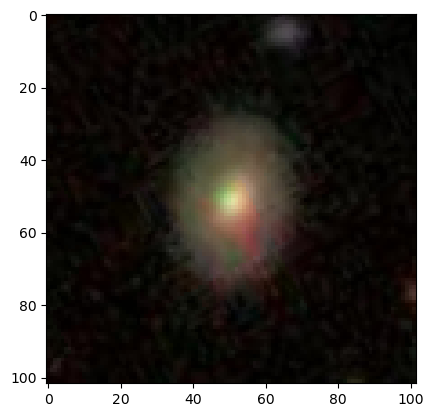

In [ ]:
entry = next(iter(valloader))
image = entry[0]
label = entry[1:]

print(len(valset))

prediction_t00 = net_t00(image.reshape(batch_size,3,image_size,image_size))
#prediction_t01 = net_t01(image.reshape(batch_size,3,image_size,image_size))

plt.imshow(image[0].permute(1,2,0).cpu().numpy())

#print(prediction.topk(1,dim=1)[1][0])

print('Guess: ' + ['smooth', 'featured', 'star'][prediction_t00.topk(1,dim=1)[1][0].item()])
print('Label: ' + ['smooth', 'featured', 'star'][label[0][0].item()])
#if label[0][0].item() == 1:#prediction_t00.topk(1,dim=1)[1][0].item() == 1:
#    print('> edgeon? G: ' + ['yes', 'no'][prediction_t01.topk(1,dim=1)[1][0]] + ', L: ' + ['yes', 'no'][label[0][1].item()])
#print('Label percentage: ' + str(label_split[0].tolist()))